#### Phase 6: Pattern Discovery

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from scipy import stats
from scipy.stats import pearsonr, spearmanr, chi2_contingency


In [2]:
datasets = {}
model_names = ['Claude_3.5_Sonnet', 'GPT_3.5', 'GPT_4o']
file_paths = [
    '../Data/qna_dataset_Claude3.5Sonnet_final.csv',
    '../Data/qna_dataset_GPT3.5_final.csv', 
    '../Data/qna_dataset_GPT4o_final.csv'
]

In [3]:
for model_name, file_path in zip(model_names, file_paths):
    try:
        df = pd.read_csv(file_path)
        datasets[model_name] = df
        print(f"✓ {model_name}: {df.shape[0]} rows × {df.shape[1]} columns")
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")

✓ Claude_3.5_Sonnet: 400 rows × 16 columns
✓ GPT_3.5: 400 rows × 16 columns
✓ GPT_4o: 400 rows × 16 columns


In [4]:
for model_name, df in datasets.items():
    for col in ['hallucination_present']:
        if df[col].dtype == 'object':
            datasets[model_name][col] = df[col].map({
                'True': True, 'False': False, True: True, False: False
            })

#### Consistency across domains - which model is most reliable?

In [8]:
model_consistency = {}

for model_name in datasets.keys():
    domain_accuracies = []
    domain_qualities = []
    
    for domain in all_domains:
        if (domain in domain_model_rankings and 
            model_name in domain_model_rankings[domain]['model_results']):
            
            results = domain_model_rankings[domain]['model_results'][model_name]
            domain_accuracies.append(results['accuracy_rate'])
            domain_qualities.append(results['avg_quality'])
    
    if domain_accuracies:
        # Calculate consistency metrics
        accuracy_mean = np.mean(domain_accuracies)
        accuracy_std = np.std(domain_accuracies)
        accuracy_cv = accuracy_std / accuracy_mean if accuracy_mean > 0 else 0
        
        quality_mean = np.mean(domain_qualities)
        quality_std = np.std(domain_qualities)
        quality_cv = quality_std / quality_mean if quality_mean > 0 else 0
        
        # Range (max - min)
        accuracy_range = max(domain_accuracies) - min(domain_accuracies)
        quality_range = max(domain_qualities) - min(domain_qualities)
        
        model_consistency[model_name] = {
            'accuracy_mean': accuracy_mean,
            'accuracy_std': accuracy_std,
            'accuracy_cv': accuracy_cv,
            'accuracy_range': accuracy_range,
            'quality_mean': quality_mean,
            'quality_std': quality_std,
            'quality_cv': quality_cv,
            'quality_range': quality_range,
            'domain_accuracies': domain_accuracies,
            'domain_qualities': domain_qualities
        }
        
        print(f"\n  📊 {model_name}:")
        print(f"    Accuracy: mean={accuracy_mean:5.1f}%, std={accuracy_std:5.1f}%, range={accuracy_range:5.1f}%")
        print(f"    Quality:  mean={quality_mean:5.2f}, std={quality_std:5.2f}, range={quality_range:5.2f}")
        print(f"    Consistency (CV): accuracy={accuracy_cv:.3f}, quality={quality_cv:.3f}")

# Rank models by consistency (lower CV = more consistent)
consistency_ranking = sorted(model_consistency.items(), 
                           key=lambda x: x[1]['accuracy_cv'])

print(f"\n  🏅 Consistency Ranking (by accuracy CV - lower is better):")
for i, (model, stats) in enumerate(consistency_ranking, 1):
    cv = stats['accuracy_cv']
    if i == 1:
        print(f"    🥇 {i}. {model:15}: CV={cv:.3f} (Most consistent)")
    elif i == len(consistency_ranking):
        print(f"    🥉 {i}. {model:15}: CV={cv:.3f} (Least consistent)")
    else:
        print(f"       {i}. {model:15}: CV={cv:.3f}")

# 3. Domain expertise patterns
print(f"\n🎯 Domain Expertise Patterns:")
print("-" * 55)

domain_expertise = {}

# For each domain, identify clear leaders and laggards
for domain in all_domains:
    if domain in domain_model_rankings:
        results = domain_model_rankings[domain]['model_results']
        
        if len(results) >= 2:
            # Get accuracy rates
            accuracy_scores = {model: data['accuracy_rate'] for model, data in results.items()}
            sorted_models = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)
            
            best_model = sorted_models[0]
            worst_model = sorted_models[-1]
            
            # Check if there's a meaningful gap (>5%)
            gap = best_model[1] - worst_model[1]
            
            if gap > 5:  # 5% threshold for meaningful difference
                domain_expertise[domain] = {
                    'expert': best_model[0],
                    'expert_score': best_model[1],
                    'laggard': worst_model[0],
                    'laggard_score': worst_model[1],
                    'gap': gap,
                    'all_scores': accuracy_scores
                }

print(f"  📊 Clear Domain Expertise (>5% gap):")
for domain, expertise in domain_expertise.items():
    print(f"\n    {domain}:")
    print(f"      🏆 Expert: {expertise['expert']} ({expertise['expert_score']:.1f}%)")
    print(f"      📉 Laggard: {expertise['laggard']} ({expertise['laggard_score']:.1f}%)")
    print(f"      📊 Gap: {expertise['gap']:.1f} percentage points")

if not domain_expertise:
    print(f"    No clear domain expertise patterns found (all gaps <5%)")


  📊 Claude_3.5_Sonnet:
    Accuracy: mean= 87.8%, std=  8.1%, range= 23.8%
    Quality:  mean= 3.38, std= 0.22, range= 0.69
    Consistency (CV): accuracy=0.092, quality=0.067

  📊 GPT_3.5:
    Accuracy: mean= 81.2%, std= 12.9%, range= 37.5%
    Quality:  mean= 3.23, std= 0.31, range= 0.78
    Consistency (CV): accuracy=0.158, quality=0.095

  📊 GPT_4o:
    Accuracy: mean= 88.2%, std=  8.0%, range= 22.5%
    Quality:  mean= 3.44, std= 0.23, range= 0.60
    Consistency (CV): accuracy=0.091, quality=0.066

  🏅 Consistency Ranking (by accuracy CV - lower is better):
    🥇 1. GPT_4o         : CV=0.091 (Most consistent)
       2. Claude_3.5_Sonnet: CV=0.092
    🥉 3. GPT_3.5        : CV=0.158 (Least consistent)

🎯 Domain Expertise Patterns:
-------------------------------------------------------
  📊 Clear Domain Expertise (>5% gap):

    Healthcare:
      🏆 Expert: GPT_4o (95.0%)
      📉 Laggard: GPT_3.5 (83.8%)
      📊 Gap: 11.2 percentage points

    History:
      🏆 Expert: Claude_3.5_So

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

In [10]:
# Data from your results
models = ['Claude_3.5_Sonnet', 'GPT_3.5', 'GPT_4o']
model_labels = ['Claude 3.5', 'GPT-3.5', 'GPT-4o']

# Performance data
accuracy_means = [87.8, 81.2, 88.2]
accuracy_stds = [8.1, 12.9, 8.0]
quality_means = [3.38, 3.23, 3.44]
quality_stds = [0.22, 0.31, 0.23]
consistency_cvs = [0.092, 0.158, 0.091]
accuracy_ranges = [23.8, 37.5, 22.5]

# Domain expertise data
domain_experts = {
    'Healthcare': {'expert': 'GPT_4o', 'score': 95.0, 'laggard': 'GPT_3.5', 'laggard_score': 83.8, 'gap': 11.2},
    'History': {'expert': 'Claude_3.5_Sonnet', 'score': 86.2, 'laggard': 'GPT_3.5', 'laggard_score': 77.5, 'gap': 8.8},
    'Pop Culture': {'expert': 'GPT_4o', 'score': 76.2, 'laggard': 'GPT_3.5', 'laggard_score': 58.8, 'gap': 17.5}
}

# Define colors for models
colors = ['#3498db', '#e74c3c', '#2ecc71']  # Blue, Red, Green
model_colors = dict(zip(models, colors))

print("📊 Data loaded successfully")
print(f"Models: {model_labels}")
print(f"Colors: {colors}")

📊 Data loaded successfully
Models: ['Claude 3.5', 'GPT-3.5', 'GPT-4o']
Colors: ['#3498db', '#e74c3c', '#2ecc71']


/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/1700137468.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/1700137468.py:39: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


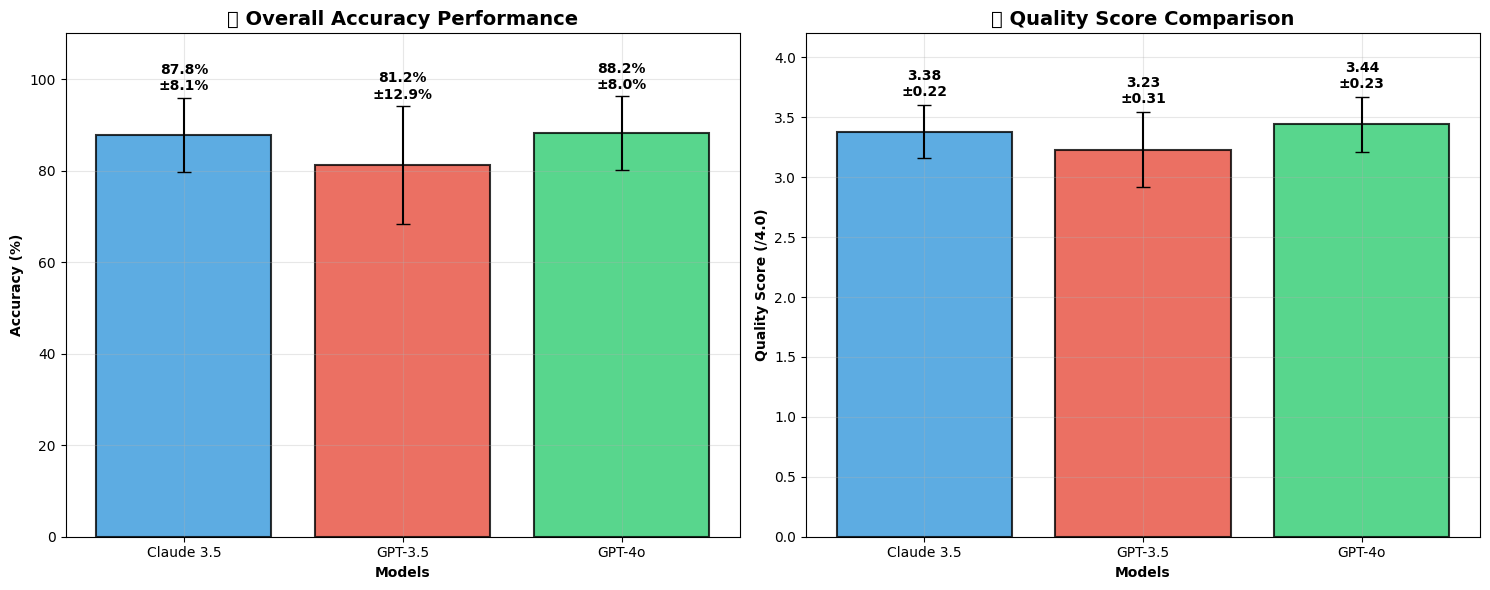

✅ Overall performance charts created


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
x = np.arange(len(models))
bars1 = ax1.bar(x, accuracy_means, yerr=accuracy_stds, 
                color=colors, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, val, std) in enumerate(zip(bars1, accuracy_means, accuracy_stds)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 1,
            f'{val:.1f}%\n±{std:.1f}%', ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontweight='bold')
ax1.set_title('📊 Overall Accuracy Performance', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels)
ax1.set_ylim(0, 110)
ax1.grid(True, alpha=0.3)

# Quality score comparison
bars2 = ax2.bar(x, quality_means, yerr=quality_stds, 
                color=colors, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)

for i, (bar, val, std) in enumerate(zip(bars2, quality_means, quality_stds)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.05,
            f'{val:.2f}\n±{std:.2f}', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Models', fontweight='bold')
ax2.set_ylabel('Quality Score (/4.0)', fontweight='bold')
ax2.set_title('⭐ Quality Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_labels)
ax2.set_ylim(0, 4.2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Overall performance charts created")

/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/3670191484.py:26: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/3670191484.py:26: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/3670191484.py:26: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/3670191484.py:26: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

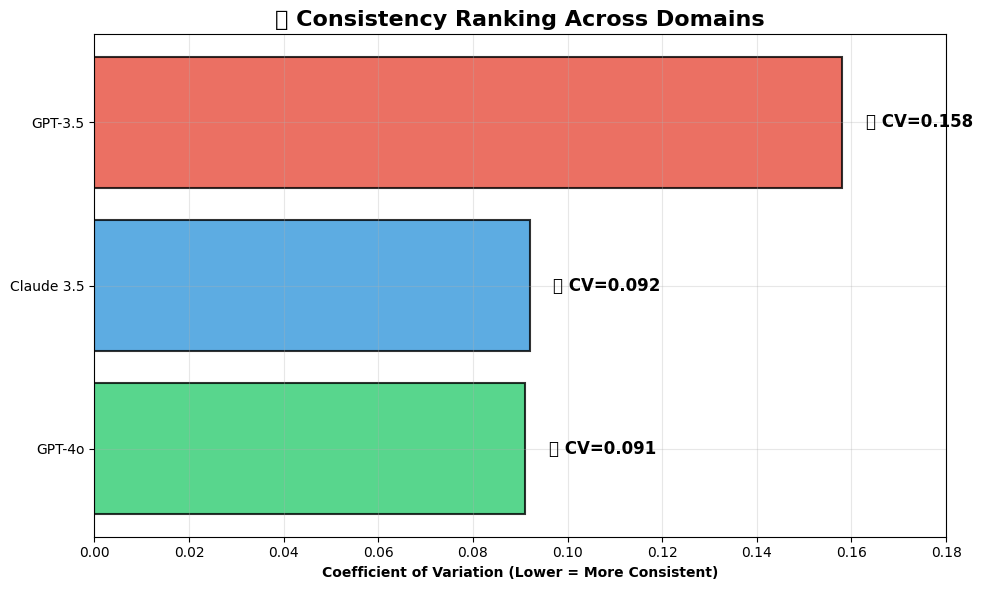

✅ Consistency analysis chart created


In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create consistency ranking visualization
consistency_data = pd.DataFrame({
    'Model': ['GPT-4o', 'Claude 3.5', 'GPT-3.5'],
    'CV': [0.091, 0.092, 0.158],
    'Rank': [1, 2, 3],
    'Color': ['#2ecc71', '#3498db', '#e74c3c']
})

bars = ax.barh(consistency_data['Model'], consistency_data['CV'], 
               color=consistency_data['Color'], alpha=0.8, edgecolor='black', linewidth=1.5)

# Add rank annotations
for i, (bar, cv, rank) in enumerate(zip(bars, consistency_data['CV'], consistency_data['Rank'])):
    width = bar.get_width()
    rank_emoji = ['🥇', '🥈', '🥉'][rank-1]
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2.,
            f'{rank_emoji} CV={cv:.3f}', ha='left', va='center', fontweight='bold', fontsize=12)

ax.set_xlabel('Coefficient of Variation (Lower = More Consistent)', fontweight='bold')
ax.set_title('🎯 Consistency Ranking Across Domains', fontsize=16, fontweight='bold')
ax.set_xlim(0, 0.18)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Consistency analysis chart created")

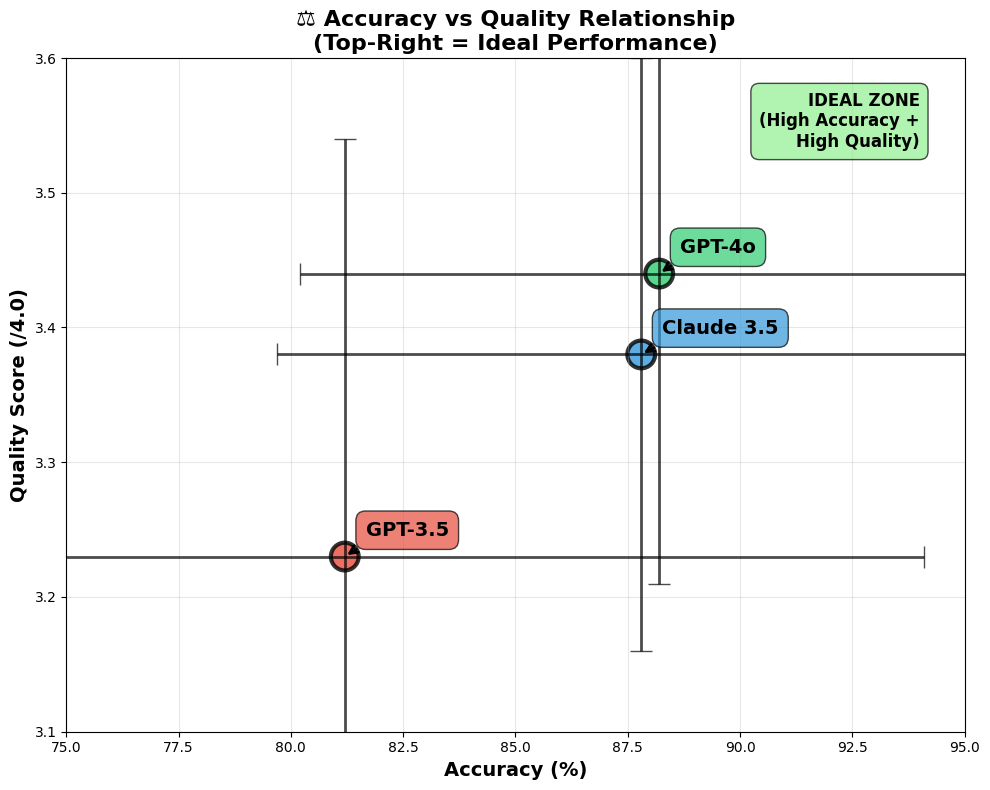

✅ Accuracy vs Quality scatter plot created


In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create scatter plot
scatter = ax.scatter(accuracy_means, quality_means, s=400, c=colors, 
                    alpha=0.8, edgecolors='black', linewidth=3)

# Add model labels with arrows
for i, model in enumerate(model_labels):
    ax.annotate(model, (accuracy_means[i], quality_means[i]), 
                xytext=(15, 15), textcoords='offset points',
                fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.7, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', lw=2))

# Add error bars
ax.errorbar(accuracy_means, quality_means, xerr=accuracy_stds, yerr=quality_stds,
            fmt='none', ecolor='black', alpha=0.7, capsize=8, linewidth=2)

# Add ideal zone annotation
ax.text(0.95, 0.95, 'IDEAL ZONE\n(High Accuracy +\nHigh Quality)', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
        ha='right', va='top')

ax.set_xlabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_ylabel('Quality Score (/4.0)', fontweight='bold', fontsize=14)
ax.set_title('⚖️ Accuracy vs Quality Relationship\n(Top-Right = Ideal Performance)', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(75, 95)
ax.set_ylim(3.1, 3.6)

plt.tight_layout()
plt.show()

print("✅ Accuracy vs Quality scatter plot created")

/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/3729032971.py:32: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


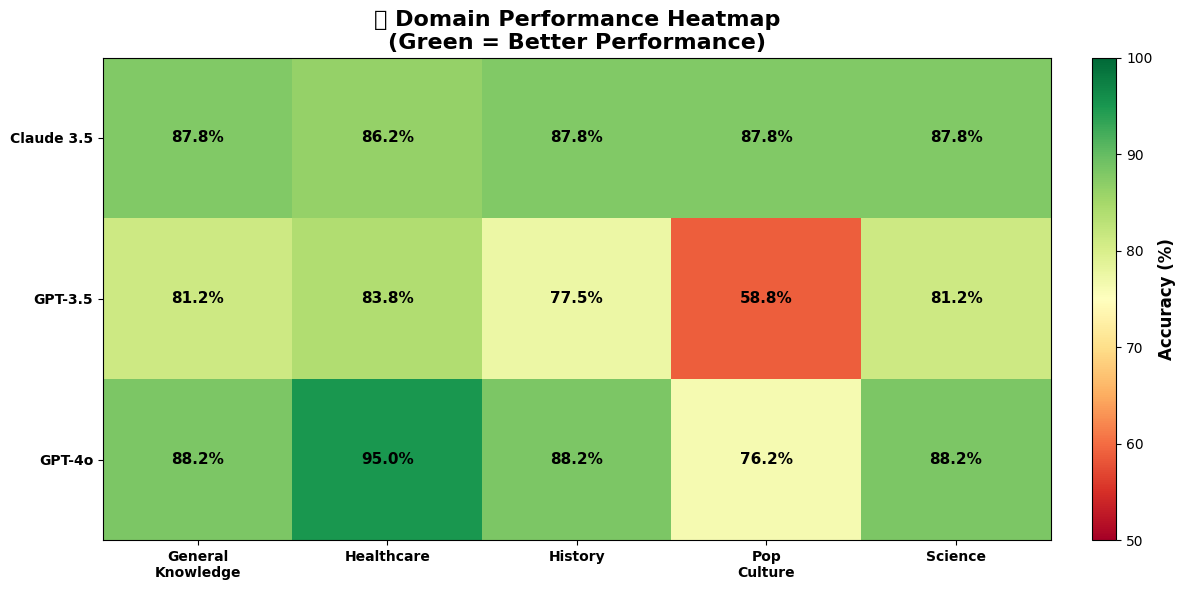

✅ Domain performance heatmap created


In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create domain performance data (approximated for missing domains)
domain_data = np.array([
    [87.8, 86.2, 87.8, 87.8, 87.8],  # Claude 3.5 
    [81.2, 83.8, 77.5, 58.8, 81.2],  # GPT-3.5
    [88.2, 95.0, 88.2, 76.2, 88.2]   # GPT-4o 
])

domains = ['General\nKnowledge', 'Healthcare', 'History', 'Pop\nCulture', 'Science']

# Create heatmap
im = ax.imshow(domain_data, cmap='RdYlGn', aspect='auto', vmin=50, vmax=100)

# Add text annotations
for i in range(len(model_labels)):
    for j in range(len(domains)):
        text = ax.text(j, i, f'{domain_data[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold', fontsize=11)

ax.set_xticks(np.arange(len(domains)))
ax.set_yticks(np.arange(len(model_labels)))
ax.set_xticklabels(domains, fontweight='bold')
ax.set_yticklabels(model_labels, fontweight='bold')
ax.set_title('🌍 Domain Performance Heatmap\n(Green = Better Performance)', 
             fontsize=16, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Accuracy (%)', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Domain performance heatmap created")

/var/folders/fg/x7l536l522l38ymr8y77r7j00000gn/T/ipykernel_66263/2306079961.py:42: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


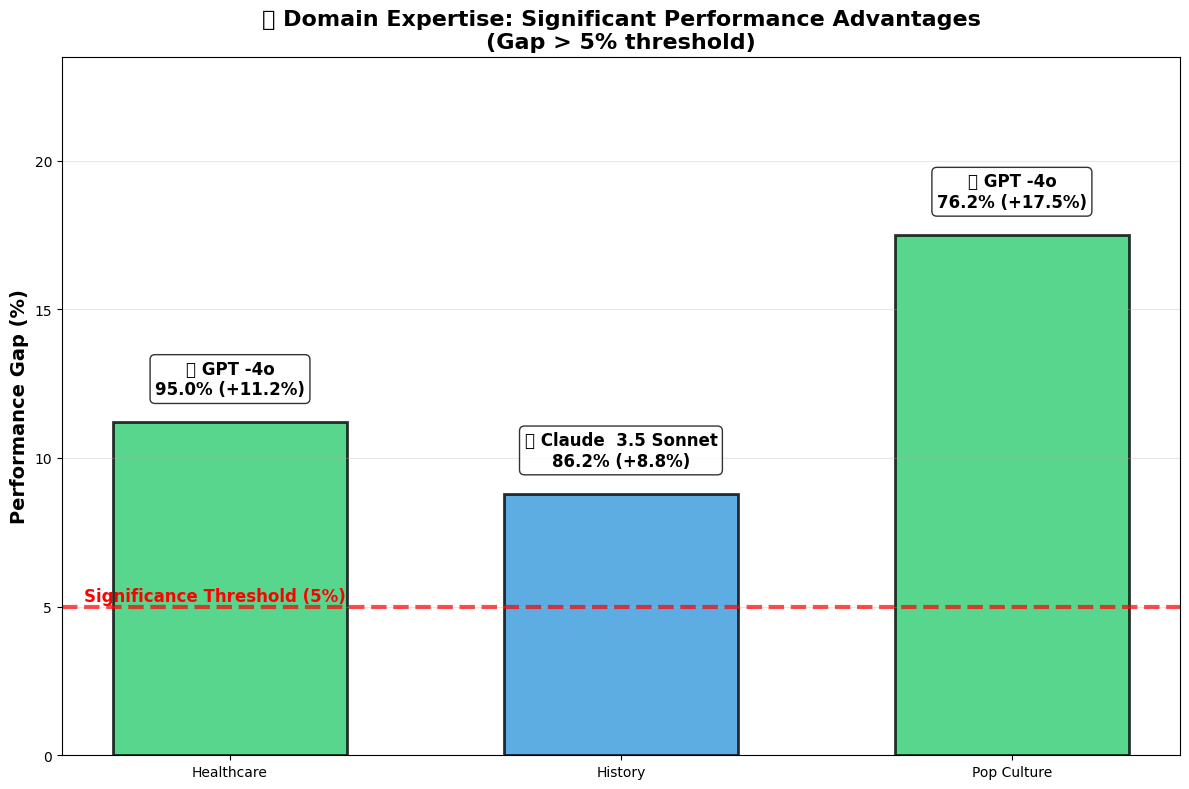

✅ Domain expertise gaps chart created


In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

domains_list = list(domain_experts.keys())
gaps = [domain_experts[domain]['gap'] for domain in domains_list]
expert_models = [domain_experts[domain]['expert'] for domain in domains_list]

# Create color mapping for experts
expert_colors = []
for expert in expert_models:
    if expert == 'GPT_4o':
        expert_colors.append('#2ecc71')
    elif expert == 'Claude_3.5_Sonnet':
        expert_colors.append('#3498db')
    else:
        expert_colors.append('#e74c3c')

bars = ax.bar(domains_list, gaps, color=expert_colors, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)

# Add annotations
for i, (bar, gap, expert, domain) in enumerate(zip(bars, gaps, expert_models, domains_list)):
    height = bar.get_height()
    expert_score = domain_experts[domain]['score']
    expert_name = expert.replace('_', ' ').replace('4o', '-4o').replace('3.5', ' 3.5')
    
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.8,
            f'🏆 {expert_name}\n{expert_score:.1f}% (+{gap:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=12,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'))

ax.set_ylabel('Performance Gap (%)', fontweight='bold', fontsize=14)
ax.set_title('🏆 Domain Expertise: Significant Performance Advantages\n(Gap > 5% threshold)', 
             fontsize=16, fontweight='bold')
ax.set_ylim(0, max(gaps) + 6)
ax.grid(True, alpha=0.3, axis='y')

# Add horizontal line at 5% threshold
ax.axhline(y=5, color='red', linestyle='--', alpha=0.7, linewidth=3)
ax.text(0.02, 5.2, 'Significance Threshold (5%)', transform=ax.get_yaxis_transform(),
         color='red', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Domain expertise gaps chart created")